<a href="https://colab.research.google.com/github/Luca-wirthner/2024_Geoinformatique_I/blob/main/script_zones_tampons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import geopandas as gpd
import pyogrio as pgr
import matplotlib.pyplot as plt

In [3]:
# The file can be accessed by using its name frome the colab directory
pgr.list_layers('zone_etude.gpkg')

array([['ze_3860', 'MultiPolygon'],
       ['perimetre_evaluation', 'Polygon']], dtype=object)

In [4]:
zone_etude = gpd.read_file('zone_etude.gpkg', layer = 'ze_3860')

In [5]:
buff_500m = zone_etude.buffer(500).union_all()
buff_1km_dif = zone_etude.buffer(1000).union_all() - zone_etude.buffer(500).union_all()
buff_5km_dif = zone_etude.buffer(5000).union_all() - zone_etude.buffer(1000).union_all()

In [6]:
buffs = {'500m': buff_500m, '1km': buff_1km_dif, '5km': buff_5km_dif}
gdf_buffs = { k: gpd.GeoDataFrame(geometry=[poly], crs='EPSG:2056') for k, poly in buffs.items()}

In [7]:
pgr.list_layers('admin.gpkg')

array([['communes', 'MultiPolygon Z'],
       ['cantons', 'MultiPolygon Z']], dtype=object)

In [8]:
communes = gpd.read_file('admin.gpkg', layer = 'communes')

In [9]:
gdf_buffs_cmns = { k: gpd.overlay(gdf_buffs[k], communes, how = 'intersection') for k in gdf_buffs}

In [10]:
gdf_buffs_cmns['500m']


,id,uuid,datum_aenderung,datum_erstellung,erstellung_jahr,erstellung_monat,grund_aenderung,herkunft,herkunft_jahr,herkunft_monat,...,bezirksnummer,kantonsnummer,name,gem_flaeche,see_flaeche,icc,shn,einwohnerzahl,hist_nr,geometry
0,537,{88D27170-ED1E-45BF-952B-D6ECCDFDC6E7},2023-11-08,2008-11-24,2006,1,Verbessert,swisstopo,2024,1,...,2224.0,22.0,Yverdon-les-Bains,1503.0,148.0,CH,CH22245938,29827,15497.0,"POLYGON Z ((2540127.532 1180161.316 509.523, 2..."
1,843,{F03B2FDF-837A-4B56-93B1-332E8BBFAC37},2023-10-24,2008-11-24,2006,1,Verbessert,swisstopo,2024,1,...,2224.0,22.0,Pomy,562.0,0.0,CH,CH22245926,864,14579.0,MULTIPOLYGON Z (((2540341.983 1179921.825 508....


<Axes: >

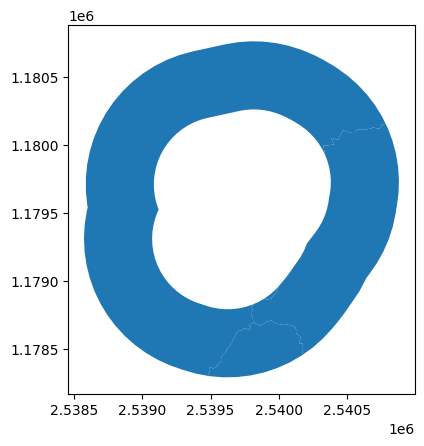

In [11]:
gdf_buffs_cmns['1km'].plot()

In [12]:
pgr.list_layers('stat_ofs.gpkg')

array([['pop_2023', 'Point'],
       ['empl_2022', 'Point']], dtype=object)

In [13]:
population = gpd.read_file('stat_ofs.gpkg', layer = 'pop_2023')
emplois = gpd.read_file('stat_ofs.gpkg', layer = 'empl_2022')

In [1]:
def sjoin_summarize(poly_lyr, pts_lyr, pts_colname, poly_newcolname):
    """
    poly_lyr:         la couche des polygones
    pts_lyr:          la couche des points
    pts_colname:      la colonne sur laquelle il faut faire la somme
    poly_newcolname:  le nom de la colonne à créer dans la couche
                      des polygones
    """
    # Faire d'abord une jointure spatiale pour associer chaque point à un polygone
    sjoin = pts_lyr.sjoin(poly_lyr, how='inner', predicate='within')

    # Faire une opération «group by» selon l'index du polygone, et calculer la somme
    somme_par_poly = sjoin.groupby(sjoin.index_right)[pts_colname].sum()

    # Enregistrer le résultat dans la couche des polygones
    poly_lyr[poly_newcolname] = poly_lyr.index.map(somme_par_poly)

In [16]:
population

,BBTOT,E_KOORD,N_KOORD,geometry
0,17,2529800,1171500,POINT (2529800 1171500)
1,29,2529800,1171600,POINT (2529800 1171600)
2,25,2529800,1171700,POINT (2529800 1171700)
3,12,2529800,1171800,POINT (2529800 1171800)
4,11,2529800,1171900,POINT (2529800 1171900)
...,...,...,...,...
3319,9,2549700,1181000,POINT (2549700 1181000)
3320,17,2549700,1183200,POINT (2549700 1183200)
3321,18,2549700,1183300,POINT (2549700 1183300)
3322,3,2549700,1184600,POINT (2549700 1184600)


In [17]:
emplois

,B08EMPT,E_KOORD,N_KOORD,geometry
0,4,2529800,1171500,POINT (2529800 1171500)
1,4,2529800,1171600,POINT (2529800 1171600)
2,4,2529800,1171700,POINT (2529800 1171700)
3,4,2529800,1171800,POINT (2529800 1171800)
4,4,2529800,1172100,POINT (2529800 1172100)
...,...,...,...,...
2158,4,2549700,1174800,POINT (2549700 1174800)
2159,4,2549700,1180300,POINT (2549700 1180300)
2160,4,2549700,1180400,POINT (2549700 1180400)
2161,4,2549700,1181000,POINT (2549700 1181000)


In [21]:
sjoin_summarize(gdf_buffs_cmns['500m'], population, 'BBTOT', 'pop_2023_sum')
sjoin_summarize(gdf_buffs_cmns['500m'], emplois, 'B08EMPT', 'empl_2022_sum')
sjoin_summarize(gdf_buffs_cmns['1km'], population, 'BBTOT', 'pop_2023_sum')
sjoin_summarize(gdf_buffs_cmns['1km'], emplois, 'B08EMPT', 'empl_2022_sum')
sjoin_summarize(gdf_buffs_cmns['5km'], population, 'BBTOT', 'pop_2023_sum')
sjoin_summarize(gdf_buffs_cmns['5km'], emplois, 'B08EMPT', 'empl_2022_sum')

In [25]:
gdf_buffs_cmns['500m']['peri'] = '500m'
gdf_buffs_cmns['1km']['peri'] = '1km'
gdf_buffs_cmns['5km']['peri'] = '5km'

In [26]:
for k in gdf_buffs_cmns:
    sjoin_summarize(gdf_buffs_cmns[k], population, 'BBTOT', 'pop_2023_sum')
    sjoin_summarize(gdf_buffs_cmns[k], emplois, 'B08EMPT', 'empl_2022_sum')
    gdf_buffs_cmns[k]['peri'] = k

In [27]:
gdf_buffs_cmns['500m']

,id,uuid,datum_aenderung,datum_erstellung,erstellung_jahr,erstellung_monat,grund_aenderung,herkunft,herkunft_jahr,herkunft_monat,...,gem_flaeche,see_flaeche,icc,shn,einwohnerzahl,hist_nr,geometry,pop_2023_sum,empl_2022_sum,peri
0,537,{88D27170-ED1E-45BF-952B-D6ECCDFDC6E7},2023-11-08,2008-11-24,2006,1,Verbessert,swisstopo,2024,1,...,1503.0,148.0,CH,CH22245938,29827,15497.0,"POLYGON Z ((2540127.532 1180161.316 509.523, 2...",3049,5097,500m
1,843,{F03B2FDF-837A-4B56-93B1-332E8BBFAC37},2023-10-24,2008-11-24,2006,1,Verbessert,swisstopo,2024,1,...,562.0,0.0,CH,CH22245926,864,14579.0,MULTIPOLYGON Z (((2540341.983 1179921.825 508....,68,88,500m


In [30]:
data_500m = gdf_buffs_cmns['500m'][['bfs_nummer', 'name', 'peri', 'pop_2023_sum', 'empl_2022_sum']]
data_1km = gdf_buffs_cmns['1km'][['bfs_nummer', 'name', 'peri', 'pop_2023_sum', 'empl_2022_sum']]
data_5km = gdf_buffs_cmns['5km'][['bfs_nummer', 'name', 'peri', 'pop_2023_sum', 'empl_2022_sum']]